In [1]:
# import packages
from scipy.io import loadmat
import numpy as np
from mayavi import mlab
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load data from file
Undata = loadmat('Testdata.mat')['Undata']

In [3]:
# Spatial domain
L = 15
# Fourier modes
n = 64
# x, y, z: grid points in 3d position space; x2: all grid points;
x2 = np.linspace(-L, L, n+1)
x = x2[0:n]
y = x
z = x
# k: grid points in frequency space; ks: fftshift to zero as center
k = (2*np.pi/(2*L))*np.concatenate((np.arange(0, n/2), np.arange(-n/2, 0)))
ks = np.fft.fftshift(k)
# meshgrid coordinate
[X, Y, Z] = np.meshgrid(x, y, z)
[Kx, Ky, Kz] = np.meshgrid(ks, ks, ks)

In [31]:
def isosurface(X, Y, Z, V, show = False, axesrange = None):
    # an substitution to isosurface in Matlab
    
    def t(a):
        """Transpose to coerce np.meshgrid output match np.mgrid output. a must
        be a 3d-array."""
        return a.transpose([1, 0, 2])
    
    if show:
        mlab.clf()
        mlab.figure(bgcolor=(1, 1, 1))
        fig = mlab.contour3d(t(X), t(Y), t(Z), t(V), opacity = 0.8, transparent = True)
        clbar = mlab.colorbar(orientation = 'vertical', nb_labels = 5)
        clbar.label_text_property.color = (0.0, 0.0, 0.0)
        clbar.label_text_property.font_size = 1
        if axesrange == None:
            axes = mlab.axes(color = (0, 0, 0), nb_labels = 5, xlabel = 'Kx', ylabel = 'Ky', zlabel = 'Kz')
        else:
            axes = mlab.axes(color = (0, 0, 0), nb_labels = 5, extent = axesrange)
        axes.title_text_property.color = (0.0, 0.0, 0.0)
        axes.label_text_property.color = (0.0, 0.0, 0.0)
        mlab.show()
    else:
        fig = mlab.contour3d(t(X), t(Y), t(Z), t(V), opacity = 0.9, transparent = True)
        
    return fig

In [5]:
# plot raw data
for item in Undata: 
    Un = np.reshape(item, (n, n, n), order = 'F')
    fig = isosurface(X, Y, Z, abs(Un), show = True, axesrange = [-20, 20, -20, 20, -20, 20])

In [32]:
# de-noise: average of Fourier Transform
Utmean = np.zeros((n,n,n))
for item in Undata:
    Un = np.reshape(item, (n, n, n), order = 'F')
    Ut = np.fft.fftn(Un)
    Utmean = Utmean + Ut
Utmean = np.fft.fftshift(Utmean)/20
fig2 = isosurface(Kx, Ky, Kz, abs(Utmean)/(abs(Utmean).max()), show = True)

In [7]:
# The center frequency (cf) is at
idx = np.unravel_index(abs(Utmean).argmax(), abs(Utmean).shape)
[cfx, cfy, cfz] = [Kx[idx], Ky[idx], Kz[idx]]
[cfx, cfy, cfz]

[1.8849555921538759, -1.0471975511965976, 0.0]

In [8]:
# filter
filterfunc = np.exp( -0.2 * ( (Kx - cfx)**2 + (Ky - cfy)**2 + (Kz - cfz)**2 ) )

In [9]:
# trajectory 3 (coordinates) * 20 (trajectory)
trajx = np.zeros(len(Undata))
trajy = np.zeros(len(Undata))
trajz = np.zeros(len(Undata))

for j in range(len(Undata)):
    
    # filter data to expose the marble
    Un = np.reshape(Undata[j], (n, n, n), order = 'F')
    Ut = np.fft.fftn(Un) # Fourier Transform
    Utn = np.fft.fftshift(Ut) # Shift center to zero
    Uftn = filterfunc * Utn # Apply filter
    Ufn = np.fft.ifftn(Uftn) # Inverse Fourier Transform
    
    # find the coordinates of the marble (marble is supposed to exert the maximum intensity)
    idx = np.unravel_index(abs(Ufn).argmax(), abs(Ufn).shape)
    [trajx[j], trajy[j], trajz[j]] = [X[idx], Y[idx], Z[idx]]

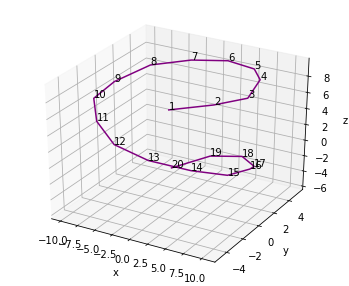

In [55]:
fig3 = plt.figure(figsize=(6,5))
ax = plt.axes(projection='3d')
ax.plot3D(trajx, trajy, trajz, 'purple')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
zdirs = np.linspace(1,20,20)

for j in range(20):
    j1 = j+1
    label = '%d' % (j1)
    ax.text(trajx[j], trajy[j], trajz[j], label)

plt.savefig('trajectory.png')

In [12]:
# In the 20th measurements, the position of the marble is at
[trajx[-1], trajy[-1], trajz[-1]]

[-5.625, 4.21875, -6.09375]

In [45]:
zdirs.shape

(20,)

In [59]:
np.array([trajx, trajy, trajz]).transpose()

array([[ 4.6875 , -4.6875 ,  9.84375],
       [ 8.4375 , -2.8125 ,  9.84375],
       [10.3125 , -0.46875,  9.375  ],
       [ 8.90625,  2.34375,  9.375  ],
       [ 6.09375,  4.21875,  8.90625],
       [ 1.40625,  5.15625,  8.4375 ],
       [-3.28125,  4.6875 ,  7.96875],
       [-7.5    ,  3.28125,  7.5    ],
       [-9.84375,  0.9375 ,  6.5625 ],
       [-9.84375, -1.40625,  6.09375],
       [-7.03125, -3.28125,  5.15625],
       [-2.8125 , -4.6875 ,  4.21875],
       [ 1.875  , -4.6875 ,  3.28125],
       [ 6.5625 , -3.75   ,  2.34375],
       [ 9.375  , -1.875  ,  0.9375 ],
       [ 9.84375,  0.46875,  0.     ],
       [ 7.96875,  2.8125 , -1.875  ],
       [ 4.21875,  4.6875 , -2.8125 ],
       [-0.9375 ,  5.15625, -4.21875],
       [-5.625  ,  4.21875, -6.09375]])